# Resubmission Paper 18

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import warnings
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# Download lexicon (run once locally)
nltk.download('vader_lexicon')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nidial\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Access file path
file_path = r"C:\Users\nidial\VS projects\PPG\ChatPaper\University\ChatGPT_Mixed_Itais.xlsx"
df = pd.read_excel(file_path)


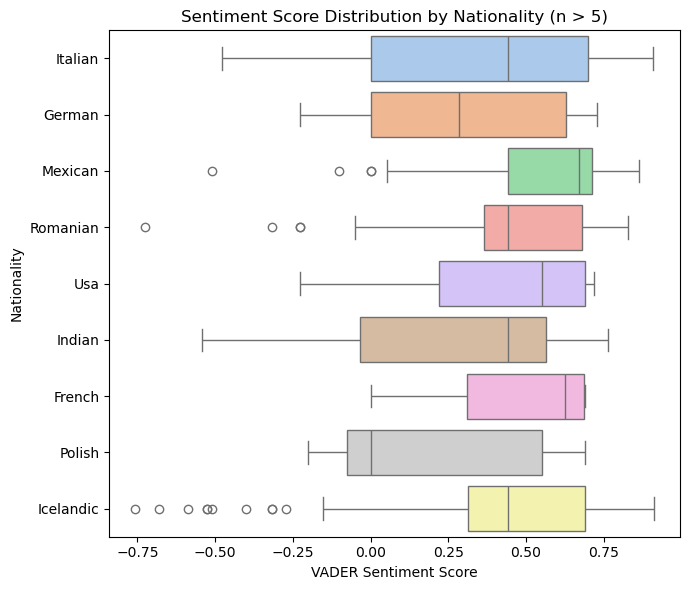

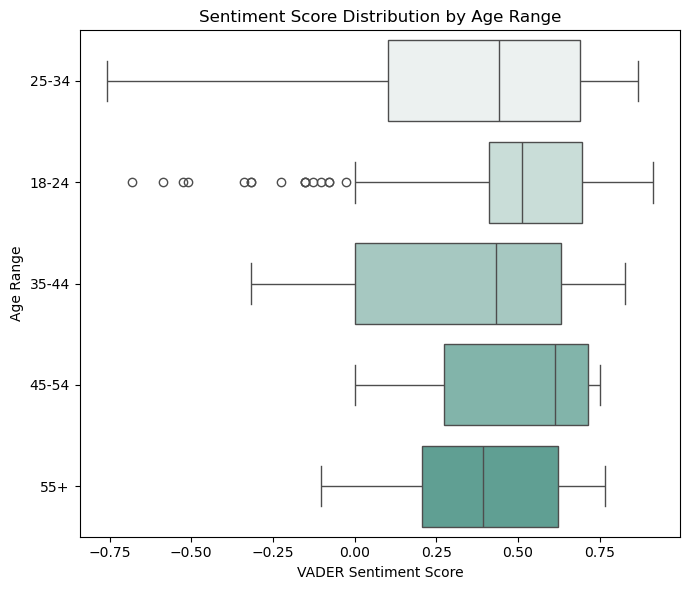

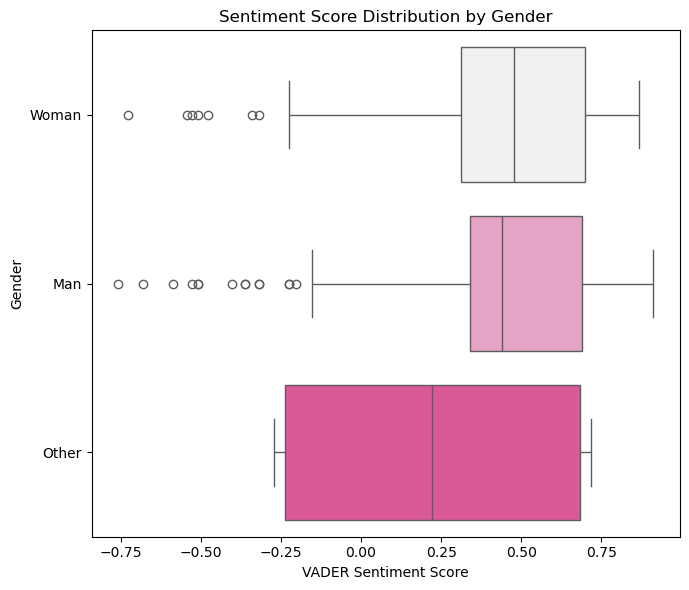

In [12]:

# Data preparation
df_clean = df.dropna(subset=['adj1', 'adj2', 'adj3'])

# Normalize values
df_clean['Nationatily'] = df_clean['Nationatily'].str.strip().str.title()
df_clean['Gender'] = df_clean['Gender'].str.strip().str.title()
df_clean['AgeRange'] = df_clean['AgeRange'].str.strip()

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Sentiment analysis
df_clean['Adj_combined'] = df_clean[['adj1', 'adj2', 'adj3']].agg(' '.join, axis=1)
df_clean['Adj_Sentiment_Score'] = df_clean['Adj_combined'].apply(lambda x: sia.polarity_scores(x)['compound'])

# === PLOT 1: Sentiment by Nationality (only if >5 participants) ===
valid_nats = df_clean['Nationatily'].value_counts()
valid_nats = valid_nats[valid_nats > 5].index
df_nats = df_clean[df_clean['Nationatily'].isin(valid_nats)]

plt.figure(figsize=(7, 6))
sns.boxplot(data=df_nats, x='Adj_Sentiment_Score', y='Nationatily', palette='pastel')
plt.title('Sentiment Score Distribution by Nationality (n > 5)')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Nationality')
plt.tight_layout()
plt.show()

# === PLOT 2: Sentiment by Age Range ===
plt.figure(figsize=(7, 6))
sns.boxplot(data=df_clean, x='Adj_Sentiment_Score', y='AgeRange', palette='light:#5A9')
plt.title('Sentiment Score Distribution by Age Range')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Age Range')
plt.tight_layout()
plt.show()

# === PLOT 3: Sentiment by Gender ===
plt.figure(figsize=(7, 6))
sns.boxplot(data=df_clean, x='Adj_Sentiment_Score', y='Gender', palette='light:#E49')
plt.title('Sentiment Score Distribution by Gender')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Gender')
plt.tight_layout()
plt.show()


In [14]:
# Group sentiment scores by gender
groups = df_clean.groupby('Gender')['Adj_Sentiment_Score'].apply(list)

# Run one-way ANOVA
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA p-value (Gender vs Sentiment Score): {p_value:.4f}")

# By AgeRange (ANOVA)
age_groups = [group['Adj_Sentiment_Score'].dropna() for name, group in df_clean.groupby('AgeRange')]
f_stat, p_age = f_oneway(*age_groups)
print(f"ANOVA p-value (Age Range vs Sentiment): {p_age:.4f}")

# Group by nationality and run ANOVA
nat_groups = df_clean.groupby('Nationatily')['Adj_Sentiment_Score'].apply(list)
f_s, p_v = f_oneway(*nat_groups)
print(f"ANOVA p-value (Nationality vs Sentiment Score): {p_v:.4f}")

ANOVA p-value (Gender vs Sentiment Score): 0.3081
ANOVA p-value (Age Range vs Sentiment): 0.0350
ANOVA p-value (Nationality vs Sentiment Score): 0.0514


In [17]:
# Adjusted (marginal) means for ChatGPT_Gender: average predicted sentiment for each ChatGPT_Gender level,
# averaging over the observed distribution of AgeRange, Gender, Nationality
# ---------------------------
def adjusted_means_by(group_var, model, data):
    levels = data[group_var].unique()
    means = []
    for lvl in levels:
        X = data.copy()
        X[group_var] = lvl
        pred = model.predict(X)
        means.append({'level': lvl, 'adj_mean': float(np.mean(pred))})
    return pd.DataFrame(means).sort_values('level')


In [20]:
cols = ['Adj_Sentiment_Score', 'ChatGPT_Gender', 'AgeRange', 'Gender', 'Nationatily']
df_clean = df_clean.dropna(subset=cols).copy()

formula = 'Adj_Sentiment_Score ~ C(ChatGPT_Gender, Treatment(reference="Genderless")) + C(AgeRange) + C(Gender, Treatment(reference = "Man")) + C(Nationatily)'
model_ols = smf.ols(formula, data=df_clean).fit(cov_type='HC3')
print("\nOLS (HC3 robust SEs):\n")
print(model_ols.summary())

emm = adjusted_means_by('ChatGPT_Gender', model_ols, df_clean)
print("\nAdjusted means of Adj_Sentiment_Score by ChatGPT_Gender (HC3 model):")
print(emm)


OLS (HC3 robust SEs):

                             OLS Regression Results                            
Dep. Variable:     Adj_Sentiment_Score   R-squared:                       0.075
Model:                             OLS   Adj. R-squared:                  0.029
Method:                  Least Squares   F-statistic:                     1.974
Date:               mið., 20 ágú. 2025   Prob (F-statistic):            0.00900
Time:                         18:38:47   Log-Likelihood:                -125.93
No. Observations:                  402   AIC:                             291.9
Df Residuals:                      382   BIC:                             371.8
Df Model:                           19                                         
Covariance Type:                   HC3                                         
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

In [24]:
#sentiment ~ gender attribution × age

formula = (
    "Adj_Sentiment_Score ~ "
    "C(ChatGPT_Gender, Treatment(reference='Male ')) * C(AgeRange) "
    "+ C(Gender) + C(Nationatily)"
)
model_ols = smf.ols(formula, data=df_clean).fit(cov_type='HC3')
print("\nOLS (HC3 robust SEs):\n")
print(model_ols.summary())

emm = adjusted_means_by('ChatGPT_Gender', model_ols, df_clean)
print("\nAdjusted means of Adj_Sentiment_Score by ChatGPT_Gender (HC3 model):")
print(emm)


OLS (HC3 robust SEs):

                             OLS Regression Results                            
Dep. Variable:     Adj_Sentiment_Score   R-squared:                       0.090
Model:                             OLS   Adj. R-squared:                  0.027
Method:                  Least Squares   F-statistic:                     2.398
Date:               mið., 20 ágú. 2025   Prob (F-statistic):           0.000196
Time:                         18:42:48   Log-Likelihood:                -122.72
No. Observations:                  402   AIC:                             299.4
Df Residuals:                      375   BIC:                             407.4
Df Model:                           26                                         
Covariance Type:                   HC3                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

In [51]:
import pandas as pd
import numpy as np
import unicodedata
import statsmodels.api as sm
from patsy import dmatrix

# --- 0) Prep ---
df = df_clean.copy()

# Your exact column names (note the earlier typo "Nationatily")
NAT_COL = 'Nationatily'   # change to 'Nationality' if that's your column

cols = ['ChatGPT_Gender','Adj_Sentiment_Score','AgeRange','Gender']
df = df.dropna(subset=cols).copy()

# --- 1) Normalize and strip weird spaces in all string categoricals ---
def normalize_str(x):
    if pd.isna(x): 
        return x
    # Normalize accents and non-breaking spaces, then strip
    x = unicodedata.normalize('NFKC', str(x))
    x = x.replace('\u00A0',' ').strip()   # replace NBSP
    return x

for c in ['ChatGPT_Gender','AgeRange','Gender']:
    df[c] = df[c].map(normalize_str)

# Inspect unique values to confirm cleaning
print("ChatGPT_Gender levels:", sorted(df['ChatGPT_Gender'].dropna().unique()))

# --- 2) Canonicalize ChatGPT_Gender labels (map variants) ---
map_gender_attr = {
    'male': 'Male', 'Male ': 'Male', 'Male ': 'Male', # trailing/NBSP
    'female': 'Female', 'nonbinary': 'Non-binary', 'non binary': 'Non-binary',
    'non-binary': 'Non-binary', 'none': 'Genderless', 'no gender': 'Genderless',
    'genderless': 'Genderless', 'ungendered': 'Genderless'
}
df['ChatGPT_Gender'] = df['ChatGPT_Gender'].replace(map_gender_attr)

# Keep only levels that actually appear after cleaning:
levels_present = df['ChatGPT_Gender'].dropna().unique().tolist()

# If you want a specific baseline, put it first *only if present*
preferred_order = ['Genderless','Male','Female']
order = [lvl for lvl in preferred_order if lvl in levels_present] + \
        [lvl for lvl in levels_present if lvl not in preferred_order]

df['ChatGPT_Gender'] = pd.Categorical(df['ChatGPT_Gender'], categories=order, ordered=False)

# Outcome must be integer codes 0..K-1 for MNLogit:
y = df['ChatGPT_Gender'].cat.codes
# (Optional) sanity check: -1 means unseen category/NaN; drop if any
mask_ok = y >= 0
df = df.loc[mask_ok].copy()
y = y.loc[mask_ok]

# --- 3) Build X with dmatrix (predictors only) ---
# Treat grouping vars as categorical
X = dmatrix(
    "0 + Adj_Sentiment_Score + C(AgeRange) + C(Gender) ",
    data=df,
    return_type="dataframe"
)
X = sm.add_constant(X, prepend=True)

# --- 1) Ensure X has a *flat*, hashable column index and no names ---
if isinstance(X.columns, pd.MultiIndex):
    # join tuple levels into strings
    X.columns = ["__".join(map(str, tup)) for tup in X.columns]
X.columns = [str(c) for c in X.columns]   # force plain strings
X.columns.name = None                     # remove column index name, if any

# --- 2) Ensure X index is simple (no MultiIndex with list-named levels) ---
if isinstance(X.index, pd.MultiIndex):
    X.index = X.index.to_flat_index()
X.index.name = None

# --- 3) Align y to X and make y a plain 1-D int array ---
y = y.loc[X.index]
y = np.asarray(y, dtype=int)

# --- 4) Safety checks ---
assert y.ndim == 1, "y must be 1-D"
assert not np.isnan(y).any(), "y contains NaN"
assert X.shape[0] == y.shape[0], "X and y must have same number of rows"
# statsmodels wants purely numeric exog:
assert all(np.issubdtype(dt, np.number) for dt in X.dtypes), "X has non-numeric columns"

# --- 5) Fit MNLogit (now should work) ---
mod = sm.MNLogit(y, X)
res = mod.fit(method="newton", maxiter=200, disp=False, cov_type="HC3")
print(res.summary())


# --- 5) Tidy Relative Risk Ratios (RRR = exp(coef)) ---
def tidy_rrr(result):
    """
    Build a tidy table of Relative Risk Ratios (RRR = exp(coef)) with CIs.
    Works regardless of whether result.params is a DataFrame with a MultiIndex
    or something flatter. Returns a regular DataFrame (no special index names).
    """
    import numpy as np
    import pandas as pd
    from scipy.stats import norm

    params = result.params
    bse = result.bse

    # Ensure DataFrames for consistent stacking
    if isinstance(params, pd.Series):
        params = params.to_frame("coef").T  # make it 1-row DataFrame
        bse = bse.to_frame("SE").T

    coef_long = params.stack().rename("coef")
    se_long   = bse.stack().rename("SE")

    # Align
    long = pd.concat([coef_long, se_long], axis=1)

    # Stats
    long["z"] = long["coef"] / long["SE"]
    long["p"] = 2 * (1 - norm.cdf(np.abs(long["z"])))
    long["RRR"] = np.exp(long["coef"])
    long["RRR_ci_lo"] = np.exp(long["coef"] - 1.96 * long["SE"])
    long["RRR_ci_hi"] = np.exp(long["coef"] + 1.96 * long["SE"])

    # If it’s a MultiIndex, set level names safely; otherwise don’t touch names
    if isinstance(long.index, pd.MultiIndex):
        # Use a TUPLE of strings (hashable) or call set_names with a list of strings
        long.index = long.index.set_names(("Outcome_vs_Baseline", "Term"))

    # Return a flat DataFrame for easy printing/CSV
    return long.reset_index()

print("\nRRR table (HC3):")
print(tidy_rrr(res).round(3))

# --- 6) Average marginal effects (easier to interpret) ---
mfx = res.get_margeff(at='overall', method='dydx')
print("\nAverage marginal effects (HC3):")
print(mfx.summary())


ChatGPT_Gender levels: ['Female', 'Genderless', 'Male']
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  402
Model:                        MNLogit   Df Residuals:                      386
Method:                           MLE   Df Model:                           14
Date:              mið., 20 ágú. 2025   Pseudo R-squ.:                 0.03384
Time:                        19:34:57   Log-Likelihood:                -295.66
converged:                      False   LL-Null:                       -306.01
Covariance Type:                  HC3   LLR p-value:                    0.1094
                y=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.4153   1.08e+07  -1.31e-07      1.000   -2.12e+07    2.12e+07
C(AgeRange)[18-24]      0.1066   1.05e+07   1.02

In [52]:
df['AgeRange'].value_counts()  # Check counts of each category

AgeRange
18-24    199
25-34    143
35-44     47
45-54      7
55+        6
Name: count, dtype: int64

## Summary:

Main driver is participant demographics (age and gender).

Younger people (18–24) are more willing to gender ChatGPT, especially as “Female”.

Women participants are more prone to gender attribution than men.

Sentiment toward ChatGPT does not explain gender attribution in this model.

In [54]:
import pandas as pd
import statsmodels.api as sm
import patsy

# --- Drop sparse gender category ---
df = df[df["Gender"] != "Other"]

# --- Collapse sparse age groups into 45+ ---
df["AgeRange"] = df["AgeRange"].replace({"45-54": "45+", "55+": "45+"})

# --- Ensure categorical types ---
df["ChatGPT_Gender"] = df["ChatGPT_Gender"].astype("category")
df["AgeRange"] = df["AgeRange"].astype("category")
df["Gender"] = df["Gender"].astype("category")

# --- Define model using Patsy ---
y, X = patsy.dmatrices(
    "ChatGPT_Gender ~ C(AgeRange) + C(Gender) + Adj_Sentiment_Score + Satisfaction",
    df,
    return_type="dataframe"
)

# Convert y to flat vector
y = df["ChatGPT_Gender"].cat.codes  # 0=Female,1=Genderless,2=Male (check order!)


# --- 1) Ensure X has a *flat*, hashable column index and no names ---
if isinstance(X.columns, pd.MultiIndex):
    # join tuple levels into strings
    X.columns = ["__".join(map(str, tup)) for tup in X.columns]
X.columns = [str(c) for c in X.columns]   # force plain strings
X.columns.name = None                     # remove column index name, if any

# --- 2) Ensure X index is simple (no MultiIndex with list-named levels) ---
if isinstance(X.index, pd.MultiIndex):
    X.index = X.index.to_flat_index()
X.index.name = None

# --- 3) Align y to X and make y a plain 1-D int array ---
y = y.loc[X.index]
y = np.asarray(y, dtype=int)

# --- 4) Safety checks ---
assert y.ndim == 1, "y must be 1-D"
assert not np.isnan(y).any(), "y contains NaN"
assert X.shape[0] == y.shape[0], "X and y must have same number of rows"
# statsmodels wants purely numeric exog:
assert all(np.issubdtype(dt, np.number) for dt in X.dtypes), "X has non-numeric columns"

# --- 5) Fit MNLogit (now should work) ---
mod = sm.MNLogit(y, X)
res = mod.fit(method="newton", maxiter=200, disp=False, cov_type="HC3")
print(res.summary())


# --- 5) Tidy Relative Risk Ratios (RRR = exp(coef)) ---
def tidy_rrr(result):
    """
    Build a tidy table of Relative Risk Ratios (RRR = exp(coef)) with CIs.
    Works regardless of whether result.params is a DataFrame with a MultiIndex
    or something flatter. Returns a regular DataFrame (no special index names).
    """
    import numpy as np
    import pandas as pd
    from scipy.stats import norm

    params = result.params
    bse = result.bse

    # Ensure DataFrames for consistent stacking
    if isinstance(params, pd.Series):
        params = params.to_frame("coef").T  # make it 1-row DataFrame
        bse = bse.to_frame("SE").T

    coef_long = params.stack().rename("coef")
    se_long   = bse.stack().rename("SE")

    # Align
    long = pd.concat([coef_long, se_long], axis=1)

    # Stats
    long["z"] = long["coef"] / long["SE"]
    long["p"] = 2 * (1 - norm.cdf(np.abs(long["z"])))
    long["RRR"] = np.exp(long["coef"])
    long["RRR_ci_lo"] = np.exp(long["coef"] - 1.96 * long["SE"])
    long["RRR_ci_hi"] = np.exp(long["coef"] + 1.96 * long["SE"])

    # If it’s a MultiIndex, set level names safely; otherwise don’t touch names
    if isinstance(long.index, pd.MultiIndex):
        # Use a TUPLE of strings (hashable) or call set_names with a list of strings
        long.index = long.index.set_names(("Outcome_vs_Baseline", "Term"))

    # Return a flat DataFrame for easy printing/CSV
    return long.reset_index()

print("\nRRR table (HC3):")
print(tidy_rrr(res).round(3))

# --- 6) Average marginal effects (easier to interpret) ---
mfx = res.get_margeff(at='overall', method='dydx')
print("\nAverage marginal effects (HC3):")
print(mfx.summary())


                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  398
Model:                        MNLogit   Df Residuals:                      384
Method:                           MLE   Df Model:                           12
Date:              mið., 20 ágú. 2025   Pseudo R-squ.:                 0.02931
Time:                        19:44:38   Log-Likelihood:                -295.81
converged:                       True   LL-Null:                       -304.74
Covariance Type:                  HC3   LLR p-value:                    0.1200
                 y=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9964      0.766     -2.605      0.009      -3.499      -0.494
C(AgeRange)[T.25-34]    -0.7967      0.327     -2.440      0.015      -1.437      -0.157
C(AgeRange)[